In [ ]:
import yaml
path = 'path/to/config' # eg multirun/2024-07-09/08-18-00/2
config = yaml.safe_load(open(f"{path}/.hydra/config.yaml"))
print(config)
print("\nMODEL:", config['model']['model'])

In [23]:
color_map_cell = {'HSPCs': '#F0027F',
 'CD4+ T cells': '#E5F5F9',
 'CD8+ T cells': '#CCECE6',
 'NK cells': '#98D8C9',
 'NKT cells': '#65C2A3',
 'CD10+ B cells': '#40AD75',
 'CD20+ B cells': '#228A44',
 'Plasma cells': '#006C2C',
 'Monocyte progenitors': '#FFEFA5',
 'CD14+ Monocytes': '#FEDE80',
 'CD16+ Monocytes': '#FEBF5A',
 'Monocyte-derived dendritic cells': '#FD9E43',
 'Plasmacytoid dendritic cells': '#FD7034',
 'Erythroid progenitors': '#F43D25',
 'Erythrocytes': '#DA141E',
 'Megakaryocyte progenitors': '#B60026'}

color_map_tissue = {
        "Bone_Marrow": "blue",
        "PBMCs": "green",
    }

color_map_batch = {
 'Oetjen_A': '#E5F5F9',
 'Oetjen_P': '#CCECE6',
 'Oetjen_U': '#98D8C9',
 'Sun_sample1_CS': '#40AD75',
 'Sun_sample2_KC': '#228A44',
 'Sun_sample3_TB': '#006C2C',
 'Sun_sample4_TC': '#FFEFA5',
 'Villani': '#FEDE80',
 'Freytag': '#FD7034',
 '10X': '#B60026'}


In [24]:
!pip install graphviz
import graphviz

import pickle
import typing
from typing import Optional

import attr
import numpy
import numpy as np

import yaml
import scanpy as sc
@attr.define()


_PHASE = "phase"
_G1 = "G1"

def load_data(config) -> sc.AnnData:
    
    adata = sc.read_h5ad(config["data_path"])
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    adata.strings_to_categoricals()

    if config.get("remove_cycling", False):
        adata = adata[adata.obs[_PHASE] == _G1].copy()
    sc.pp.highly_variable_genes(adata, n_top_genes=config["n_hvgs"], subset=True)
    return adata

tree = pickle.load(open(f"{path}/tree.pkl", "rb"))
config = yaml.safe_load(open(f"{path}/.hydra/config.yaml"))
adata = load_data(config["data"])
obs = adata.obs

def get_leaves(node):
    leaf_ids = []
    def _get_leaves(node):
        if node is None:
            return
        if node.is_leaf:
            leaf_ids.extend(node.dp_ids)
        else:
            _get_leaves(node.right_child)
            _get_leaves(node.left_child)
    _get_leaves(node)
    return leaf_ids

def get_fillcolor(node, obs, color_by):
    if color_by == 'tissue':
        color_map = color_map_tissue
        celltypes = obs.iloc[get_leaves(node)]["tissue"].value_counts()
    elif color_by == 'batch':
        color_map = color_map_batch
        celltypes = obs.iloc[get_leaves(node)]["batch"].value_counts()
    elif color_by == 'cell':
        color_map = color_map_cell
        celltypes = obs.iloc[get_leaves(node)]["final_annotation"].value_counts()
    else: 
        raise NotImplementedError
    celltypes = celltypes / celltypes.sum()

    fillcolor = ""
    for cell, proportion in celltypes.items():
        fillcolor += f"{color_map[cell]};{proportion}:"
    fillcolor = fillcolor[:-1]
    return fillcolor


def add_nodes(dot, tree, obs, color_by, node_size):

    def _add_node(dot, node, obs, color_by, node_size, parent_id=None):
        if node is None:
            return
        if obs.iloc[get_leaves(node)]["final_annotation"].value_counts().sum()==0:
            return
        leaf_ids = get_leaves(node)
        num_samples = len(leaf_ids)
        if num_samples == 0:
            return
        node_size = max(0.1, np.sqrt(num_samples) / 100)
        fillcolor = get_fillcolor(node, obs, color_by)
                # Set the width and height of the node based on the calculated node size
        if node_size:
            dot.node(f"{node.node_id}", label="", style="wedged", shape="circle", fillcolor=fillcolor, width=str(node_size), height=str(node_size))
        else:
            dot.node(f"{node.node_id}", label="", style="wedged", shape="circle", fillcolor=fillcolor)

        if parent_id is not None:
            dot.edge(parent_id, f"{node.node_id}")
        if not node.is_leaf:
            _add_node(dot, node.left_child, obs, color_by, node_size, parent_id=f"{node.node_id}")
            _add_node(dot, node.right_child, obs, color_by, node_size, parent_id=f"{node.node_id}")
    _add_node(dot, tree, obs, color_by, node_size)        
    return dot


/home/mvandenhi/anaconda3/envs/clonesctreevae/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [25]:
color_by = 'batch'
node_size = True
savefigs = True

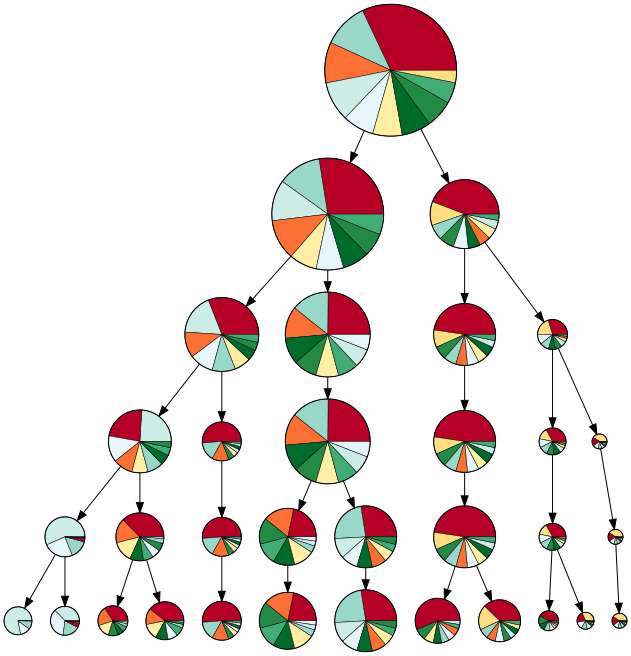

In [26]:
dot = graphviz.Digraph('', comment='', filename="mytree", format="svg")
dot.attr(ranksep='0.3')  # Reduce the edge length

add_nodes(dot, tree, obs, color_by, node_size)  
if savefigs:
    dot.render(cleanup=True)
dot

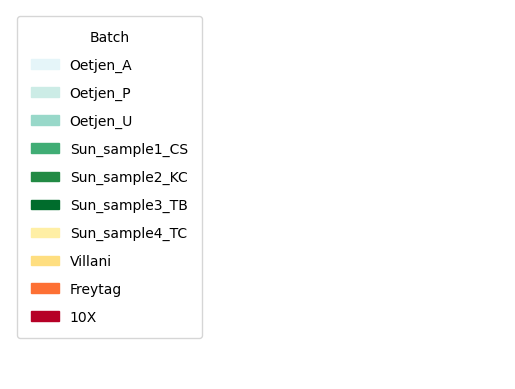

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Your color map
if color_by == 'batch':
    color_map = color_map_batch
elif color_by == 'tissue':
    color_map = color_map_tissue
elif color_by == 'cell':
    color_map = color_map_cell

# Create figure and axis (ax) for the plot
fig, ax = plt.subplots()

# Create a list to hold the legend handles
legend_handles = []

for label, color in color_map.items():
    # Create a patch (a colored box) for each item in the color_map
    patch = mpatches.Patch(color=color, label=label)
    legend_handles.append(patch)

# Create the legend from the list of patches
# Set the location to 'upper left' to align it to the left
# You can adjust the borderpad, labelspacing, and handlelength to manage the spacing and size
legend = ax.legend(handles=legend_handles, loc='upper left', borderpad=1, labelspacing=1, handlelength=2)

# Set the legend title
legend.set_title('Batch', prop={'size': 10})

# Remove axis to display only the legend
ax.axis('off')
if savefigs:
    plt.savefig('legend_plot.svg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()